In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./mini_10000.csv")

In [3]:
data.sample(10)

,unique_identifier,native word,english word
1265,nep1266,जाँदैछ,jaandaichha
4033,nep4034,डोयन,doyne
7802,nep7803,सिमलपानीमा,simalpanima
3959,nep3960,चैतन्य,chaitanya
5717,nep5718,च्यापम्यान,chapman
4028,nep4029,इरिच,erich
7510,nep7511,सरकारप्रधान,sarkarpradhan
5746,nep5747,सिलवाल,slwl
4180,nep4181,नन्दना,nandana
8782,nep8783,लेउतीको,leutiko


## Data Preparation

In [4]:
devanagari_words = data["native word"].values
roman_words = data["english word"].values

In [5]:
len(devanagari_words), len(roman_words)

(10000, 10000)

In [6]:
devanagari_characters = set()
roman_characters = set()

for word in devanagari_words:
    for character in word:
        devanagari_characters.add(character)

for word in roman_words:
    for character in word:
        roman_characters.add(character)

In [7]:
devanagari_characters = sorted(list(devanagari_characters))
roman_characters = sorted(list(roman_characters))

In [8]:
devanagari_words[:10], roman_words[:10]

(array(['मुस्कुराउँदै', 'मान्दछन्', 'भएझैं', 'हराउँछ', 'मुन्टो', 'सोचेर',
        'प्रवृत्तिलाई', 'भट्टाचार्यले', 'सर्दै', 'मूर्तिहरू'], dtype=object),
 array(['muskuraundai', 'mandachhan', 'bhaejhain', 'haraaunchha', 'munto',
        'sochera', 'prawrittilai', 'bhattacharyale', 'sardai', 'murtiharu'],
       dtype=object))

In [9]:
max_input_sequence_length = max([len(x) for x in devanagari_words])
max_output_sequence_length = max([len(x) for x in roman_words])

max_input_sequence_length, max_output_sequence_length

(19, 23)

In [10]:
print(f"Number of samples: {len(devanagari_words)}")
print(f"Number of unique input characters: {len(devanagari_characters)}")
print(f"Number of unique output characters: {len(roman_characters)}")
print(f"Max sequence length for inputs before: {max_input_sequence_length}")
print(f"Max sequence length for outputs before: {max_output_sequence_length}")

Number of samples: 10000
Number of unique input characters: 61
Number of unique output characters: 26
Max sequence length for inputs before: 19
Max sequence length for outputs before: 23


## Preparing data for Encoder and Decoder
We need to prepare the data for encoder input which will be devanagari words and for decoder input while training will be roman words and the target words is just same as the decoder input but one timestep ahead.

In [11]:
# preparing our vocabulary
unk_token = "?"
pad_token = "_"
start_token = "<"
end_token = ">"

In [12]:
special_tokens = [unk_token, pad_token, start_token, end_token]

In [13]:
roman_vocab = special_tokens + list(roman_characters)
devanagari_vocab = [unk_token, pad_token] + list(devanagari_characters)

In [14]:
len(roman_vocab), len(devanagari_vocab)

(30, 63)

In [15]:
stoi_roman = {ch:i for i,ch in enumerate(roman_vocab)}
stoi_devanagari = {ch:i for i,ch in enumerate(devanagari_vocab)}

In [16]:
stoi_roman[unk_token] == stoi_devanagari[unk_token]

True

In [17]:
input_texts = devanagari_words
target_texts = []

for word in roman_words:
  target_texts.append(start_token + word + end_token)

In [18]:
max_input_sequence_length = max([len(x) for x in input_texts])
max_output_sequence_length = max([len(x) for x in target_texts])

max_input_sequence_length, max_output_sequence_length

(19, 25)

In [19]:
input_texts[:10], target_texts[:10]

(array(['मुस्कुराउँदै', 'मान्दछन्', 'भएझैं', 'हराउँछ', 'मुन्टो', 'सोचेर',
        'प्रवृत्तिलाई', 'भट्टाचार्यले', 'सर्दै', 'मूर्तिहरू'], dtype=object),
 ['<muskuraundai>',
  '<mandachhan>',
  '<bhaejhain>',
  '<haraaunchha>',
  '<munto>',
  '<sochera>',
  '<prawrittilai>',
  '<bhattacharyale>',
  '<sardai>',
  '<murtiharu>'])

In [20]:
num_encoder_tokens = len(devanagari_vocab)
num_decoder_tokens = len(roman_vocab)

num_encoder_tokens, num_decoder_tokens

(63, 30)

In [21]:
max_input_sequence_length, max_output_sequence_length

(19, 25)

In [22]:
encoder_input_data = np.zeros(
    (len(input_texts), max_input_sequence_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_output_sequence_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_output_sequence_length, num_decoder_tokens), dtype="float32"
)

encoder_input_data.shape, decoder_input_data.shape, decoder_input_data.shape

((10000, 19, 63), (10000, 25, 30), (10000, 25, 30))

In [23]:
stoi_roman

{'?': 0,
 '_': 1,
 '<': 2,
 '>': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29}

In [24]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, character in enumerate(input_text): # each word iterating
    encoder_input_data[i, t, stoi_devanagari[character]] = 1.0
  # if the word is sometimes less than the max seq then just add the padding token which has 0 index and in one hot encoding the position will be [1 0 0...]
  encoder_input_data[i, t+1: , stoi_devanagari["_"]] = 1.0 # padding for min length word

  for t, character in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, stoi_roman[character]] = 1.0
    if t > 0:
      # decoder target data ahead by 1 timestep and dont include start character "<"
      decoder_target_data[i, t - 1, stoi_roman[character]] = 1.0 # just start storing the ohe vector only after a timestep but start from index 0 so
      # when start at t=1 store at position 0 but store next character after "start" token

  decoder_input_data[i, t+1:, stoi_roman["_"]] = 1.0
  # padding to match the length of all word
  decoder_target_data[i, t:, stoi_roman["_"]] = 1.0

In [25]:
encoder_input_data[10].shape

(19, 63)

In [26]:
decoder_input_data[0].shape

(25, 30)

In [27]:
decoder_target_data[0].shape

(25, 30)

In [28]:
for t, t_ in zip(decoder_input_data[0], decoder_target_data[0]):
  print(f"When input is {np.argmax(t)} : target is {np.argmax(t_)}")
  if np.argmax(t_) == 3:
    print("End of token")
    break

When input is 2 : target is 16
When input is 16 : target is 24
When input is 24 : target is 22
When input is 22 : target is 14
When input is 14 : target is 24
When input is 24 : target is 21
When input is 21 : target is 4
When input is 4 : target is 24
When input is 24 : target is 17
When input is 17 : target is 7
When input is 7 : target is 4
When input is 4 : target is 12
When input is 12 : target is 3
End of token


In [29]:
stoi_roman[end_token]

3

## Encoder Decoder Architecture

In [30]:
import keras

In [31]:
# configuration
LATENT_DIM = 256
BATCH_SIZE = 32
EPOCHS = 100

In [32]:
num_encoder_tokens, num_decoder_tokens

(63, 30)

In [33]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(LATENT_DIM, return_state=True)
# output from the encoder is not needed, only the states are needed
encoder_outputs, state_hidden, state_cell = encoder(encoder_inputs)
encoder_states = [state_hidden, state_cell]
# the encoder state act as the representation vector for decoder

In [34]:
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [35]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [36]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [37]:
import tensorflow
from tensorflow.keras.utils import plot_model

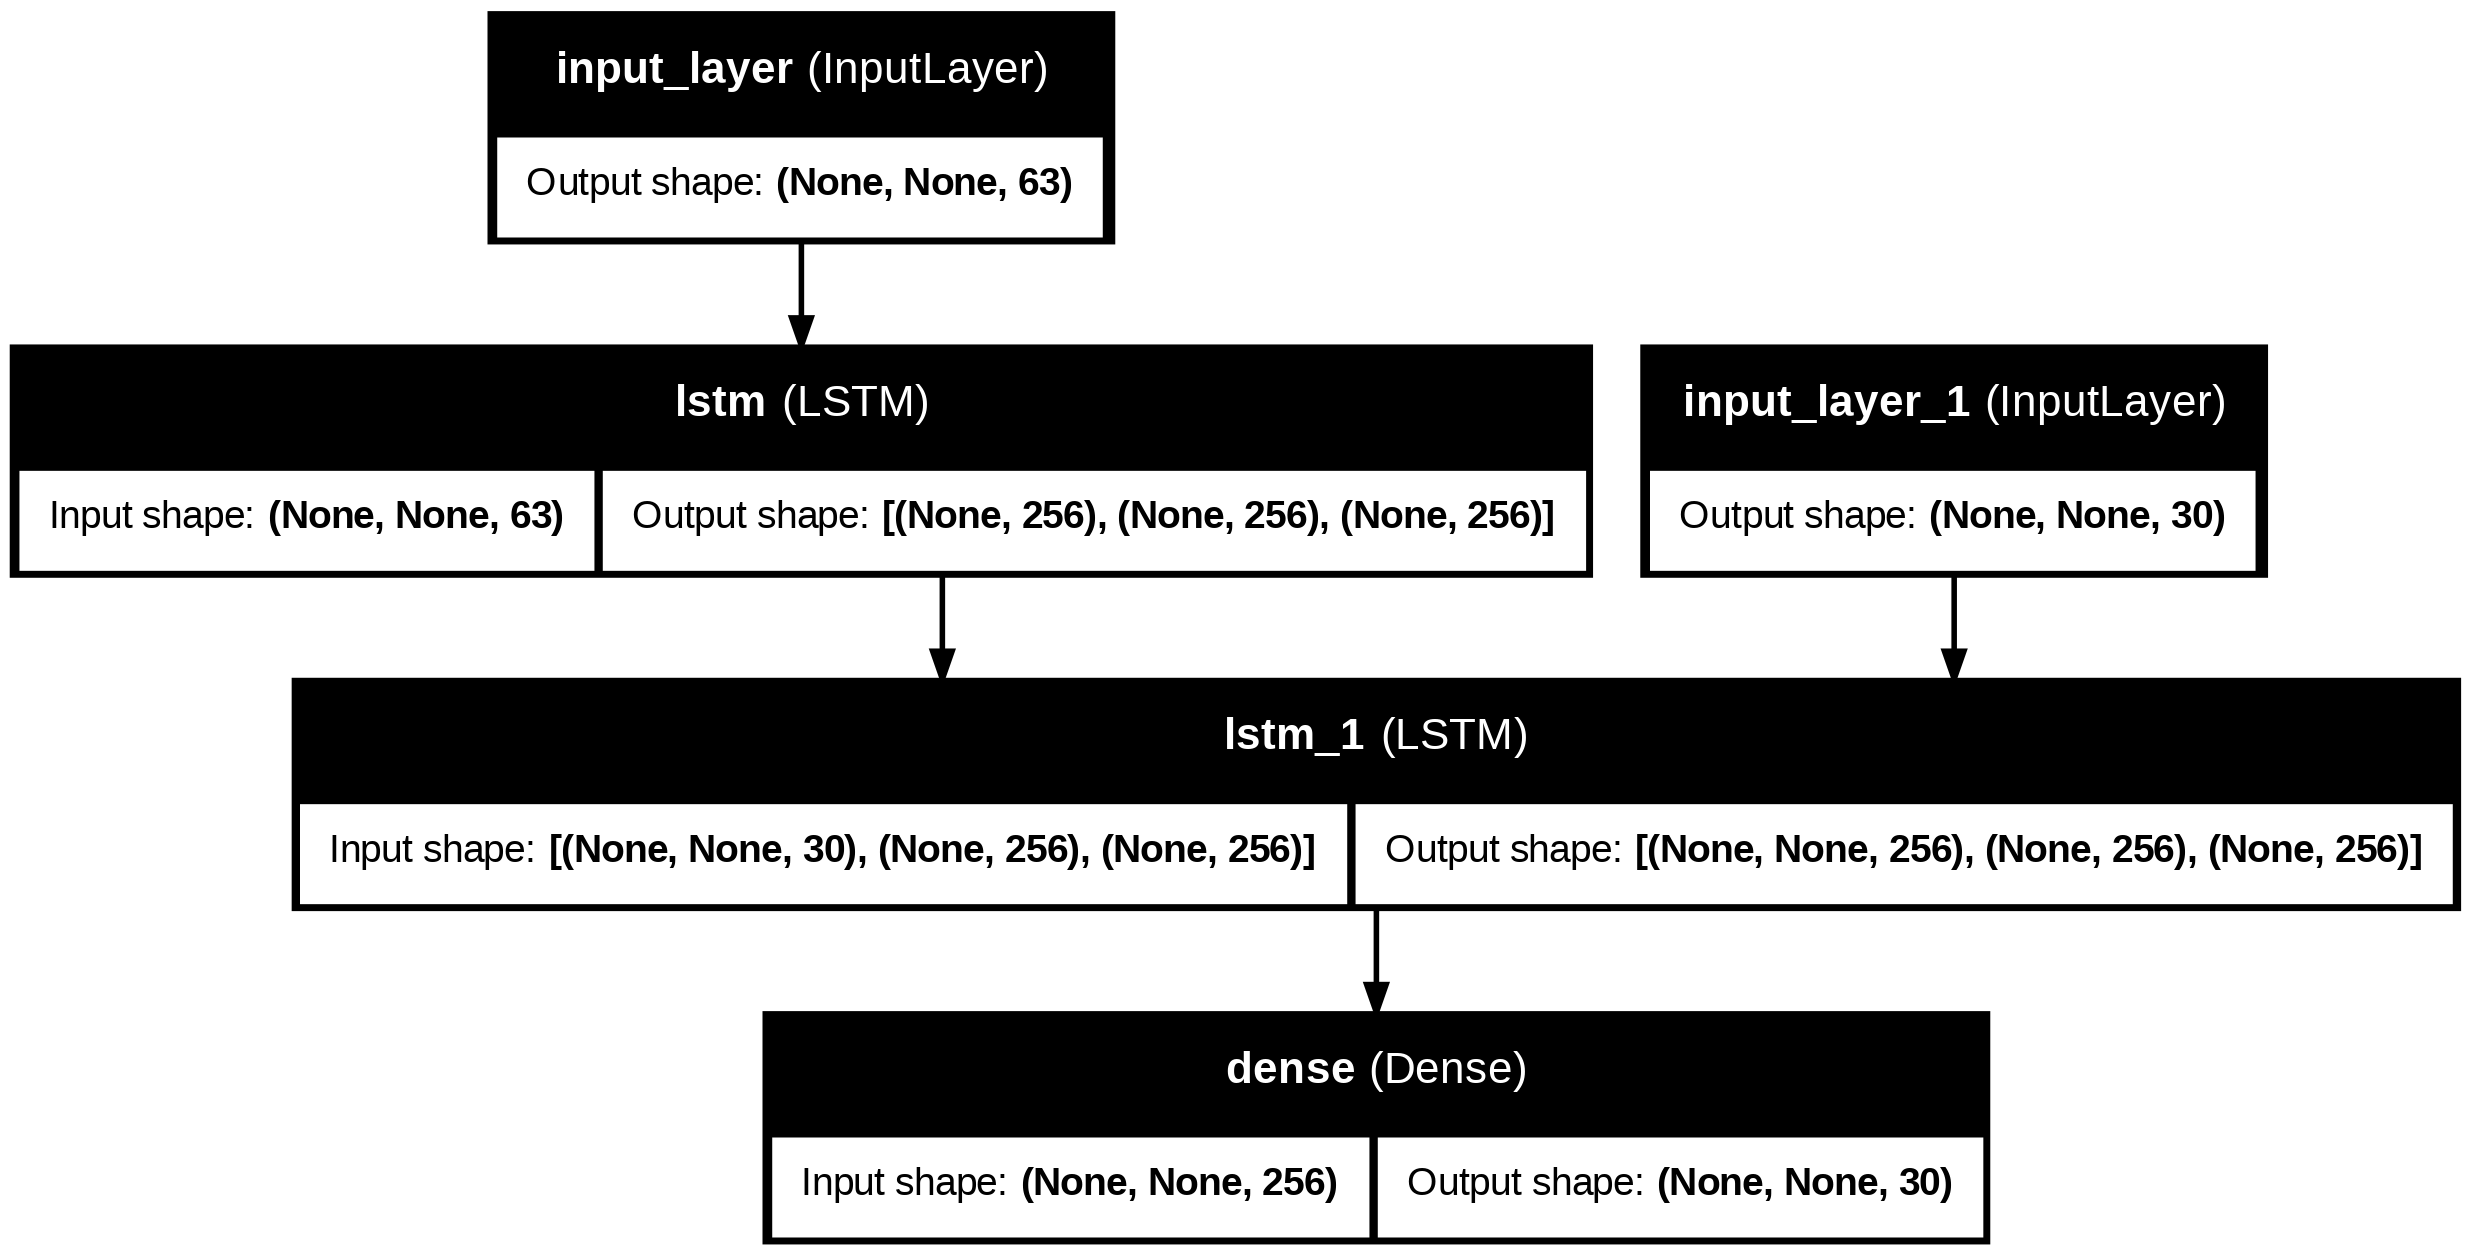

In [38]:
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

## Training our model 0

In [39]:
model_history_0 = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=5
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [40]:
model.save("model_0.keras")

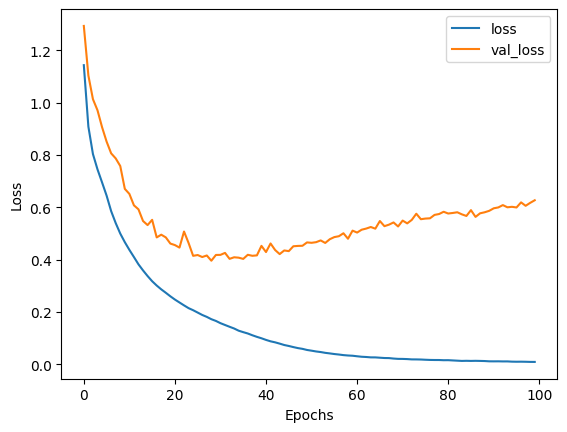

In [41]:
import matplotlib.pyplot as plt

plt.plot(model_history_0.history["loss"], label="loss")
plt.plot(model_history_0.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

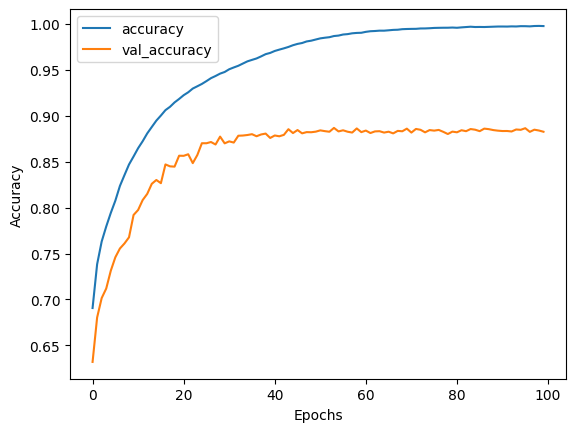

In [42]:
plt.plot(model_history_0.history["accuracy"], label="accuracy")
plt.plot(model_history_0.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Translation

In [43]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [44]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [45]:
reverse_input_char_index = dict((i, char) for char, i in stoi_devanagari.items())
reverse_target_char_index = dict((i, char) for char, i in stoi_roman.items())

In [71]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, stoi_roman["<"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        # decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == ">" or len(decoded_sentence) > max_output_sequence_length:
            stop_condition = True
        else:
          decoded_sentence += sampled_char

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [81]:
for seq_index in range(5,100,10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("\n")
    print(f"Input word: {input_texts[seq_index]}")
    print(f"Output word: {decoded_sentence}")



Input word: सोचेर
Output word: sochera


Input word: अन्ततिर
Output word: antatira


Input word: परिषदका
Output word: parishadka


Input word: सिलगड़ी
Output word: silgadhi


Input word: रचनाको
Output word: rachanako


Input word: कुनामा
Output word: kunama


Input word: कथानकको
Output word: kathanakko


Input word: लेखाइ
Output word: lekhai


Input word: शब्दमा
Output word: shabdama


Input word: दिदीलाई
Output word: didilai


In [56]:
devnagari_text = "मनोज"
devanagari_text_token = [stoi_devanagari[x] for x in devnagari_text]

devanagari_text_token

[40, 35, 59, 23]

In [57]:
def one_hot_encode_text(token: list):
  input_data = np.zeros((max_input_sequence_length, num_encoder_tokens))
  for i, t in enumerate(token):
    input_data[i, t] = 1.0
  input_data[i+1:, stoi_devanagari[pad_token]] = 1.0
  return input_data

In [92]:
input_encoded = one_hot_encode_text(devanagari_text_token).reshape(1, max_input_sequence_length, num_encoder_tokens)

input_encoded.shape

(1, 19, 63)

In [94]:
decode_sequence(input_encoded)

'manaj'

In [88]:
x = encoder_input_data[0]

x = x.reshape(1, max_input_sequence_length, num_encoder_tokens)

In [89]:
decode_sequence(x)

'muskuraundai'

In [90]:
for seq_index in range(1):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("\n")
    print(f"Input word: {input_texts[seq_index]}")
    print(f"Output word: {decoded_sentence}")



Input word: मुस्कुराउँदै
Output word: muskuraundai


In [91]:
x = encoder_input_data[0:1]

x.shape

(1, 19, 63)

In [95]:
def translate(text: str):
  devanagari_text_token = [stoi_devanagari[x] for x in text]
  input_encoded = one_hot_encode_text(devanagari_text_token).reshape(1, max_input_sequence_length, num_encoder_tokens)
  return decode_sequence(input_encoded)
  decoded = decode_sequence(x)
  return decoded

In [96]:
texts = [
    "नेपाल",
    "मेरो",
    "सुन्दर",
    "देश",
    "खुशी",
    "सगरमाथा",
    "राम्रो",
    "लामो",
    "किताब",
    "पुस्तक",
    "खाना"
]

In [97]:
for text in texts:
  print(f"Devanagari: {text} \t Roman: {translate(text)}")

Devanagari: नेपाल 	 Roman: nepal
Devanagari: मेरो 	 Roman: mero
Devanagari: सुन्दर 	 Roman: sunder
Devanagari: देश 	 Roman: desh
Devanagari: खुशी 	 Roman: khushi
Devanagari: सगरमाथा 	 Roman: sagarmath
Devanagari: राम्रो 	 Roman: ramro
Devanagari: लामो 	 Roman: lhamo
Devanagari: किताब 	 Roman: kitab
Devanagari: पुस्तक 	 Roman: pustak
Devanagari: खाना 	 Roman: khana
